# SARSA Algorithm

### Tested on CliffWalkingEnv

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import math
import numpy as np
import gym
import gym.envs.toy_text

%matplotlib inline

## Expected Value SARSA will be build upon the QLearningAgent class from Q-Learning Algo notebook

## Expected Value SARSA Algorithm
 
#### 1. Initlialize Q(s,a) with all zeros
#### 2. Using the current Q(s,a) get the best action to take by following - 

##### 2.a - (THE CHANGE!) V function is the expectation over Q functions for different actions wrt the action probability density
$$V(s) = \mathbb{E}_{a_i ~ \pi(a_i|s)}Q(s,a_i)$$

##### 2.b - Get the new Q function using -
$$ \hat Q(s_t,a_t) = r + \gamma*V(s)$$

##### 2.c - Smooth update of Q function using moving average -
$$Q(s_t,a_t)=\alpha*(\hat Q(s_t,a_t)) + (1-\alpha)*Q(s_t,a_t)$$
Where, $\alpha$ is the learning rate

##### 2.d - Get the best action using - 
$$\pi^*(s) = argmax_a Q(s,a)$$

#### 3 - $\epsilon$ - greedy exploration -
Take a random action with probability $\epsilon$, otherwise use best action


In [2]:
class ExpValSarsaAgent:
    
    #Step 1
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    #Step 2.a
    def get_value(self, state):
        """
        V_{pi}(s) = sum _{over a_i} {pi(a_i | s) * Q(s, a_i)}
        """
        possible_actions = self.get_legal_actions(state)

        epsilon = self.epsilon
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        #First get the probability distribution
        state_value = 0
        num_actions = len(possible_actions)
        for action in possible_actions:
            #If the action is the best action
            #p(a/s) = (1-E) + E/num_actions
            if action == self.get_best_action(state):
                p_a_s = (1-epsilon) + epsilon/num_actions
            #If not the best action
            #p(a/s) = E/num_actions
            else:
                p_a_s = epsilon/num_actions
            state_value += p_a_s * self.get_qvalue(state, action)

        return state_value

    #Steps 2.b, 2.c
    def update(self, state, action, reward, next_state):
        """
        Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """
        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha
        
        #Get new_q first using V(s')
        new_q = reward + gamma*self.get_value(next_state)
        #Get moving averaged q_func with new_q and the older q_value
        q_func_avg = learning_rate*new_q + (1-learning_rate)*self.get_qvalue(state, action)

        self.set_qvalue(state, action, q_func_avg)

    #Step 3
    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        #Best action is the argmax over the new functions
        q_actions = []
        for action in possible_actions:
            q_actions.append(self.get_qvalue(state, action))
        best_action = possible_actions[np.argmax(q_actions)]
            
        return best_action

    #Step 4
    def get_action(self, state):
        """
        Taking into account E-Greedy Exploration!
        """
        possible_actions = self.get_legal_actions(state)
        action = None

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon

        ore_or_oit = np.random.choice([0,1], p =[epsilon, 1-epsilon])
        #If wanna explore
        if ore_or_oit == 0:
            chosen_action = np.random.choice(possible_actions) #Over uniform dist
        #If wanna exploit
        else:
            chosen_action = self.get_best_action(state)
            
        return chosen_action

## Train Time

In [4]:
env = gym.envs.toy_text.CliffWalkingEnv()
n_actions = env.action_space.n

print(env.__doc__)


    This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.

    Adapted from Example 6.6 (page 106) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    http://incompleteideas.net/book/bookdraft2018jan1.pdf

    With inspiration from:
    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py

    The board is a 4x12 matrix, with (using Numpy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center

    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
    and a reset to the start. An episode terminates when the agent reaches the goal.
    


In [5]:
#x:start, T:exit, C:cliff, o: flat ground
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [6]:
def play_and_train(env, agent, t_max=10**4):
    """
    This function runs a full game till t_max
    """
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)

        agent.update(s, a, r, next_s)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

In [9]:
agent = ExpValSarsaAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                           get_legal_actions=lambda s: range(n_actions))


EVSARSA mean reward = -28.57


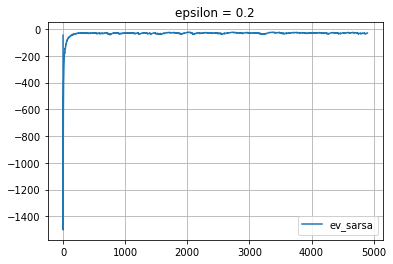

In [10]:
from IPython.display import clear_output
import pandas as pd

def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

rewards = []

for i in range(5000):
    rewards.append(play_and_train(env, agent))
    #Here epsilon is constant
    if i % 100 == 0:
        clear_output(True)
        print('ExpValEVSARSA mean reward =', np.mean(rewards[-100:]))
        plt.title("epsilon = %s" % agent.epsilon)
        plt.plot(moving_average(rewards), label='ev_sarsa')
        plt.grid()
        plt.legend()
        plt.show()

In [12]:
def draw_policy(env, agent):
    """ Prints CliffWalkingEnv policy with arrows. Hard-coded. """
    n_rows, n_cols = env._cliff.shape

    actions = '^>v<'

    for yi in range(n_rows):
        for xi in range(n_cols):
            if env._cliff[yi, xi]:
                print(" C ", end='')
            elif (yi * n_cols + xi) == env.start_state_index:
                print(" X ", end='')
            elif (yi * n_cols + xi) == n_rows * n_cols - 1:
                print(" T ", end='')
            else:
                print(" %s " %
                      actions[agent.get_best_action(yi * n_cols + xi)], end='')
        print()

In [13]:
print("ExpValSARSA")
draw_policy(env, agent)

ExpValSARSA
 >  >  >  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
